In [1]:
# Imports
import pandas as pd
from wer import wer # TODO Does this work outside pycharm?
import numpy as np
import matplotlib.pyplot as plt

In [2]:


# Read the ctms to a dataframe
column_names=["Filename", "segment", "start", "duration", "token"]
gold_ctms_file = "../data/test-61-70970-clean_hires-ctm_no_frame_def_par-ctm"
gold_ctms_df = pd.read_csv(gold_ctms_file, sep=' ', names=column_names, index_col=False, engine='python')

created_ctms_file = "../data/2020_12_14_06_55_PM_ctm"
created_ctms_df = pd.read_csv(created_ctms_file, sep=' ', names=column_names, index_col=False, engine='python')


In [3]:
# Create end-time column
'''df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
If you get the SettingWithCopyWarning you can do it this way also:

fn = lambda row: row.a + row.b # define a function for the new column
col = df.apply(fn, axis=1) # get column data with an index
df = df.assign(c=col.values) # assign values to column 'c'
'''
gold_ctms_df["end"] = gold_ctms_df.apply(lambda row: row.start + row.duration, axis=1)
created_ctms_df["end"] = created_ctms_df.apply(lambda row: row.start + row.duration, axis=1)

In [ ]:
# examine data
gold_ctms_df.head()


In [ ]:
created_ctms_df.head()


In [4]:
# Initialize frame counts and get list of files.

# Iterate file by file
list_of_filenames = gold_ctms_df["Filename"].unique().tolist()
number_of_files = len(list_of_filenames)

slow_total_correct_empty_frames = []
slow_total_correct_token_frames = []
slow_total_incorrect_token_frames = []
slow_total_number_of_frames = []

In [5]:
# Simple but very slow method of comparing files. Time takes about 10% of file length
# Assumes one frame might have multiple tokens.
# If one of those is correct gets a point.

for filename in list_of_filenames:
    correct_empty_frames = 0
    correct_token_frames = 0
    incorrect_token_frames = 0
    number_of_frames = 0
    
    df_current_gold_ctm = gold_ctms_df.loc[gold_ctms_df['Filename'] == filename][["start", "end", "token"]]
    df_current_created_ctm = created_ctms_df.loc[created_ctms_df['Filename'] == filename][["start", "end", "token"]]
    
    # Iterate by frame (this could be much faster, but this is lot more simpler)
    endtime = int(df_current_gold_ctm["end"].max() * 1000) # in ms
    framerate = 10 # in ms
    for i in range(0, endtime, framerate):
        current_time = i / 1000
        gold_tokens_set = set(df_current_gold_ctm.loc[(df_current_gold_ctm["start"] <= current_time) & (df_current_gold_ctm["end"] >= current_time)]["token"].unique())
        created_tokens_set = set(df_current_created_ctm.loc[(df_current_created_ctm["start"] <= current_time) & (df_current_created_ctm["end"] >= current_time)]["token"].unique())
       #%% 
        if (0 == len(gold_tokens_set)) and (0 == len(created_tokens_set)):
            correct_empty_frames += 1
        
        elif not gold_tokens_set.isdisjoint(created_tokens_set):
            correct_token_frames += 1
        else:
            incorrect_token_frames += 1
        
        number_of_frames += 1
            
    slow_total_correct_token_frames.append(correct_token_frames)
    slow_total_correct_empty_frames.append(correct_empty_frames)
    slow_total_incorrect_token_frames.append(incorrect_token_frames)
    slow_total_number_of_frames.append(number_of_frames)
    #%%

In [6]:
# Faster method of doing frame-by-frame comparison

fast_total_correct_empty_frames = []
fast_total_correct_token_frames = []
fast_total_incorrect_token_frames = []

# Create dataframe with index every framerate (10ms) and initialize with silence
for filename in list_of_filenames:
    correct_empty_frames = 0
    correct_token_frames = 0
    incorrect_token_frames = 0
    number_of_frames = 0

    df_current_gold_ctm = gold_ctms_df.loc[gold_ctms_df['Filename'] == filename][["start", "end", "token"]]
    df_current_created_ctm = created_ctms_df.loc[created_ctms_df['Filename'] == filename][["start", "end", "token"]]

    endtime = int(max(df_current_gold_ctm["end"].max(), df_current_created_ctm["end"].max()) * 1000) # in ms
    framerate = 10 # in ms
    frames_current_gold_ctm = ["!SIL" for x in range(0, endtime + framerate, framerate)]
    frames_current_created_ctm = ["!SIL" for x in range(0, endtime + framerate, framerate)]

    # Go over the ctm token by token and use times to put that token into those indexes
    for frames_and_ctm in [[df_current_gold_ctm, frames_current_gold_ctm], [df_current_created_ctm, frames_current_created_ctm]]:
        for ctm_row in frames_and_ctm[0].itertuples():

            # Calculate the indexes with framerate
            tokens_start_index = int(ctm_row.start * 1000 / framerate)
            tokens_end_index = int(ctm_row.end * 1000 / framerate)
            for index in range(tokens_start_index, tokens_end_index + 1):
                frames_and_ctm[1][index] = ctm_row.token

    for gold_frame, created_frame in zip(frames_current_gold_ctm, frames_current_created_ctm):
        if gold_frame == "!SIL" and created_frame == "!SIL":
            correct_empty_frames += 1
        elif gold_frame == created_frame:
            correct_token_frames += 1
        else:
            incorrect_token_frames += 1

    fast_total_correct_token_frames.append(correct_token_frames)
    fast_total_correct_empty_frames.append(correct_empty_frames)
    fast_total_incorrect_token_frames.append(incorrect_token_frames)

# Do zip comparison.


In [7]:
ctm_mistakes_seconds = []
for filename in list_of_filenames:

    df_current_gold_ctm = gold_ctms_df.loc[gold_ctms_df['Filename'] == filename][["start", "end", "token"]]
    df_current_created_ctm = created_ctms_df.loc[created_ctms_df['Filename'] == filename][["start", "end", "token"]]

    # ["OP", "REF", "HYP"]
    # "OK","SUB","INS", "***", "DEL", "***"
    wer_results, token_comparisons = wer(df_current_gold_ctm["token"].tolist(), df_current_created_ctm["token"].tolist(), True)

    # Iterate three things
    gold_iterator = df_current_gold_ctm.itertuples()
    created_iterator = df_current_created_ctm.itertuples()
    for comparison_row in token_comparisons[1:]:
        if comparison_row[0] == "OK" or comparison_row[0] == "SUB":

            gold_ctm_row = next(gold_iterator)
            created_ctm_row = next(created_iterator)

            start_difference = created_ctm_row.start - gold_ctm_row.start
            end_difference = created_ctm_row.end - gold_ctm_row.end
            ctm_mistakes_seconds.append([start_difference, end_difference])

        elif comparison_row[0] == "INS":
            created_ctm_row = next(created_iterator)
        elif comparison_row[0] == "DEL":
            gold_ctm_row = next(gold_iterator)
        else:
            print("Something went terribly wrong")
            break

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2cb4f070d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2cb4f077d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2cb4f06ad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2cb4f09a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2cb4f09dd0>],
 'means': []}

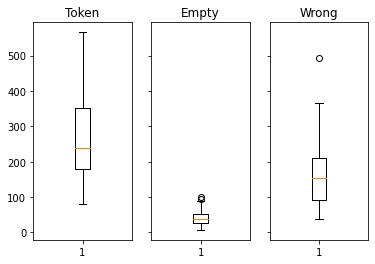

In [8]:
# STATISTICS
slow_correct_empty_np_arr = np.asarray(slow_total_correct_empty_frames)
slow_correct_token_np_arr = np.asarray(slow_total_correct_token_frames)
slow_incorrect_np_arr = np.asarray(slow_total_incorrect_token_frames)

difference_np_arr = np.asarray(ctm_mistakes_seconds)

slow_correct_mean = np.mean(slow_correct_token_np_arr)
slow_correct_median = np.median(slow_correct_token_np_arr)
slow_correct_max = np.max(slow_correct_token_np_arr)
slow_correct_min = np.min(slow_correct_token_np_arr)

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.set_title('Token')
ax2.set_title('Empty')
ax3.set_title('Wrong')
ax1.boxplot(slow_correct_token_np_arr)
ax2.boxplot(slow_correct_empty_np_arr)
ax3.boxplot(slow_incorrect_np_arr)

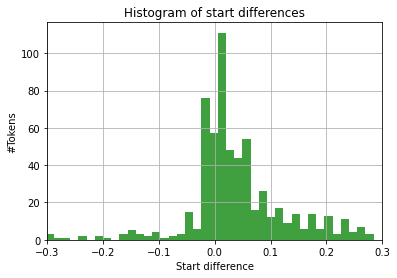

In [13]:
plt.hist(difference_np_arr[:,0], 100, facecolor='g', alpha=0.75)

plt.xlabel('Start difference')
plt.ylabel('#Tokens')
plt.title('Histogram of start differences')
plt.xlim(-0.3,0.3)
#plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

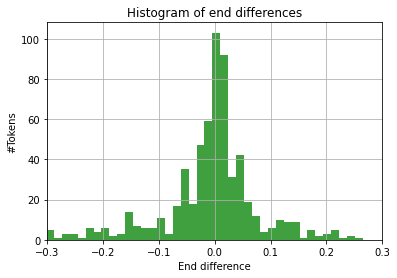

In [14]:
plt.hist(difference_np_arr[:,1], 100, facecolor='g', alpha=0.75)

plt.xlabel('End difference')
plt.ylabel('#Tokens')
plt.title('Histogram of end differences')
plt.xlim(-0.3, 0.3)
#plt.ylim(0, 0.03)
plt.grid(True)
plt.show()